# Choosing the Best Model - Activation Functions
In the previous notebook (Model Attempts), it seems that the model that performs best on the testing dataset (in terms of mean squared error) uses a batch normalization, the second channel for HSV colors, 4 convolutional layers (1: 8 neurons, 5x5 with a 3x3 pooling layer; 2: 16 neurons, 5x5 with a 3x3 pooling layer; 3: 32 neurons, 2x2 with a 2x2 pooling layer; 4: 64 neurons, 2x2 with a 2x2 pooling layer), two dense layers (512, 128 neurons) with two drop out layers (0.2).

Previous models attempted to use different HSV channels, different combinations of neurons and grid sizes in convolutional layers and pooling layers and different drop out rates. 

This notebook will see how changing the activation functions change the model performance.

In [2]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage import io, filters, measure
from scipy import ndimage
from keras.models import Sequential
from keras.layers.advanced_activations import PReLU
import cv2
from glob import glob
from sklearn.model_selection import train_test_split

C:\Users\echel\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\echel\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\echel\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\echel\AppData\Roaming\Python\Python36\site-

In [30]:
# Import watermark and print package versions
%load_ext watermark
%watermark -v -m -p matplotlib.pyplot,numpy,pandas,tensorflow,skimage,scipy,keras.models,cv2,glob,sklearn.model_selection,PIL -g

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.7
IPython 7.11.1

matplotlib.pyplot 3.1.2
numpy 1.18.1
pandas 0.25.3
tensorflow 1.5.0
skimage 0.16.2
scipy 1.4.1
keras.models 2.1.5
cv2 4.1.2
glob unknown
sklearn.model_selection 0.22.1
PIL 7.0.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
Git hash   :


In [3]:
# Find location of image files and labeled images
data = glob('data/raw/resized/with_people/splits/*hsv*.png')
labels = glob('data/processed/dots/with_people/splits/*.png')

# Split into the training and testing data
train_X, test_X = train_test_split(data, test_size=0.2, random_state=33)
train_Y, test_Y = train_test_split(labels, test_size=0.2, random_state=33)

In [4]:
# Create function to make a data generator for the model
def gather_images(images, labels, batch_size=10): 
    """ Takes the original and labeled images, combines them into np """
    """ arrays, and passes to model"""
    while 1: 
        for offset in range(0, len(images), batch_size): 
            X = [] # empty list for training data
            Y = [] # empty list for labels 
            for img in images[offset:offset+batch_size]: # for each image in the list
                img_temp = cv2.imread(img)
                img_flatten = np.array(img_temp)[:,:,1:2]
                X.append(img_flatten) # and add to list for X
            for lab in labels[offset:offset+batch_size]: # for each label in the list
                label_temp = io.imread(lab, as_gray=True)
                labels_temp = measure.label(label_temp)
                label_flatten = labels_temp.max() # create np array
                Y.append(label_flatten) # and add to list for y
            yield (np.array(X), np.array(Y).reshape(len(Y),1)) # yield X and y for the model

# Best Model: 
- Normalization Layer
- Convolutional Layer (8 nodes, 5x5, relu activation)
- Max Pooling Layer (3x3)
- Convolutional Layer (16 nodes, 5x5, relu activation)
- Max Pooling Layer (3x3)
- Convolutional Layer (32 nodes, 2x2, relu activation)
- Max Pooling Layer (2x2) 
- Convolutional Layer (64 nodes, 2x2, relu activation)
- Max Pooling Layer (2x2)
- Flatten Layer
- Dense Layer (512 nodes, relu activation)
- Dropout Layer (0.2)
- Dense Layer (128 nodes, relu activation)
- Dropout Layer (0.2)
- Dense Layer (1 node, linear activation)

Pros to ReLU activation: Quick to run (efficient), doesn't have an exact linear relationship but is considered a linear activation function

Cons to ReLU activation: Vanishing gradient is possible

In [5]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/10
347/347 [==============================]347/347 [==============================] - 261s 752ms/step - loss: 0.2473 - mean_squared_error: 0.2473 - mean_absolute_error: 0.2065 - val_loss: 0.1967 - val_mean_squared_error: 0.1967 - val_mean_absolute_error: 0.1542

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 191s 551ms/step - loss: 0.1942 - mean_squared_error: 0.1942 - mean_absolute_error: 0.1693 - val_loss: 0.1820 - val_mean_squared_error: 0.1820 - val_mean_absolute_error: 0.1422

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 189s 545ms/step - loss: 0.1894 - mean_squared_error: 0.1894 - mean_absolute_error: 0.1678 - val_loss: 0.1616 - val_mean_squared_error: 0.1616 - val_mean_absolute_error: 0.1448

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 191s 550ms/step - lo

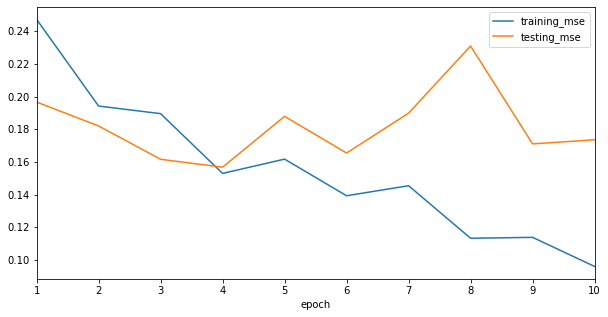

In [6]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()

# Activation Function: Sigmoid
Pros: Outputs restricted between 0 and 1, creates a smooth gradient, makes clear predictions

Cons: Computationally expensive, vanishing gradient is possible

In [9]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation='sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Epoch 1/10
347/347 [==============================]347/347 [==============================] - 181s 521ms/step - loss: 0.3443 - mean_squared_error: 0.3443 - mean_absolute_error: 0.3015 - val_loss: 0.2750 - val_mean_squared_error: 0.2750 - val_mean_absolute_error: 0.2160

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 193s 555ms/step - loss: 0.3046 - mean_squared_error: 0.3046 - mean_absolute_error: 0.2577 - val_loss: 0.2721 - val_mean_squared_error: 0.2721 - val_mean_absolute_error: 0.2487

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 178s 513ms/step - loss: 0.3045 - mean_squared_error: 0.3045 - mean_absolute_error: 0.2575 - val_loss: 0.2682 - val_mean_squared_error: 0.2682 - val_mean_absolute_error: 0.2522

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 175s 504ms/step - loss: 0.3042 - mean_squared_error: 0.3042 - mean_absolute_error: 0.2574 - v

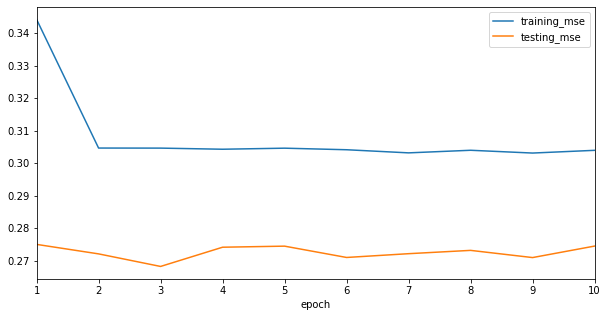

In [10]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()

# Activation Function: Linear
Pros: Allows for multiple outputs

Cons: Flattens the result into a single value, doesn't allow for back propagation

In [11]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation='linear'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation='linear'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation='linear'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation='linear'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='linear'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='linear'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Epoch 1/10
347/347 [==============================]347/347 [==============================] - 170s 490ms/step - loss: 0.4440 - mean_squared_error: 0.4440 - mean_absolute_error: 0.3101 - val_loss: 0.2428 - val_mean_squared_error: 0.2428 - val_mean_absolute_error: 0.2729

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 180s 519ms/step - loss: 0.2444 - mean_squared_error: 0.2444 - mean_absolute_error: 0.2473 - val_loss: 0.2272 - val_mean_squared_error: 0.2272 - val_mean_absolute_error: 0.2956

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 197s 568ms/step - loss: 0.2283 - mean_squared_error: 0.2283 - mean_absolute_error: 0.2397 - val_loss: 0.2309 - val_mean_squared_error: 0.2309 - val_mean_absolute_error: 0.2911

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 186s 537ms/step - loss: 0.2184 - mean_squared_error: 0.2184 - mean_absolute_error: 0.2330 - v

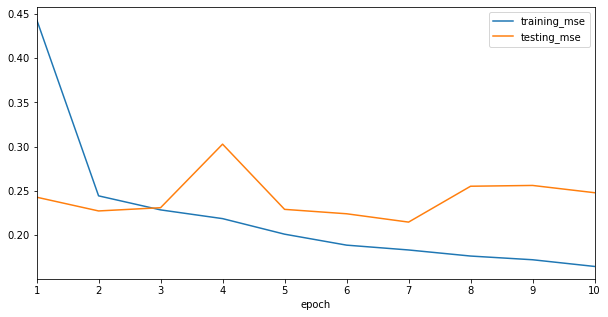

In [12]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()

# Activation Function: Tanh

Pros: Centered around zeros, so ideal for datasets that have strongly negative or positive values

Cons: Computationally expensive, vanishing gradient is possible

In [13]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation='tanh'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='tanh'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Epoch 1/10
347/347 [==============================]347/347 [==============================] - 177s 509ms/step - loss: 0.3205 - mean_squared_error: 0.3205 - mean_absolute_error: 0.2763 - val_loss: 0.2601 - val_mean_squared_error: 0.2601 - val_mean_absolute_error: 0.2985

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 178s 513ms/step - loss: 0.2376 - mean_squared_error: 0.2376 - mean_absolute_error: 0.2465 - val_loss: 0.2096 - val_mean_squared_error: 0.2096 - val_mean_absolute_error: 0.2506

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 175s 504ms/step - loss: 0.2116 - mean_squared_error: 0.2116 - mean_absolute_error: 0.2368 - val_loss: 0.1999 - val_mean_squared_error: 0.1999 - val_mean_absolute_error: 0.2548

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 200s 576ms/step - loss: 0.1927 - mean_squared_error: 0.1927 - mean_absolute_error: 0.2283 - v

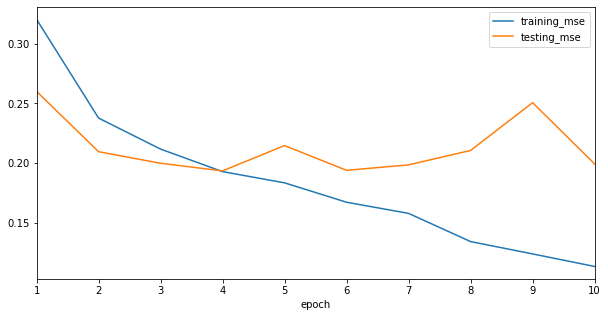

In [14]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()

# Activation Function: Hard Sigmoid

Pros: Computationally faster than the normal sigmoid

Cons: Vanishing gradient is possible

In [15]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation='hard_sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation='hard_sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation='hard_sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation='hard_sigmoid'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='hard_sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='hard_sigmoid'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Epoch 1/10
347/347 [==============================]347/347 [==============================] - 192s 554ms/step - loss: 0.3511 - mean_squared_error: 0.3511 - mean_absolute_error: 0.3112 - val_loss: 0.2735 - val_mean_squared_error: 0.2735 - val_mean_absolute_error: 0.2358

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 189s 545ms/step - loss: 0.3039 - mean_squared_error: 0.3039 - mean_absolute_error: 0.2589 - val_loss: 0.2721 - val_mean_squared_error: 0.2721 - val_mean_absolute_error: 0.2522

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 189s 546ms/step - loss: 0.3046 - mean_squared_error: 0.3046 - mean_absolute_error: 0.2572 - val_loss: 0.2689 - val_mean_squared_error: 0.2689 - val_mean_absolute_error: 0.2703

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 189s 544ms/step - loss: 0.3044 - mean_squared_error: 0.3044 - mean_absolute_error: 0.2567 - v

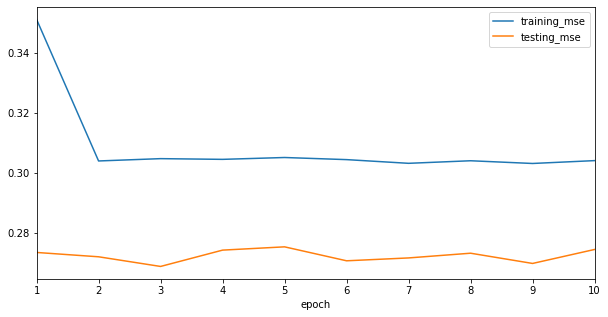

In [16]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()

# Activation Function: PReLU

Pros: Allows a negative slope to be learned 

Cons: May perform differently for different problems

In [17]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation=PReLU()),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation=PReLU()),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation=PReLU()),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation=PReLU()),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=PReLU()),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation=PReLU()),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Epoch 1/10
347/347 [==============================]347/347 [==============================] - 201s 578ms/step - loss: 0.2438 - mean_squared_error: 0.2438 - mean_absolute_error: 0.2030 - val_loss: 0.2082 - val_mean_squared_error: 0.2082 - val_mean_absolute_error: 0.1418

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 202s 581ms/step - loss: 0.2006 - mean_squared_error: 0.2006 - mean_absolute_error: 0.1728 - val_loss: 0.1770 - val_mean_squared_error: 0.1770 - val_mean_absolute_error: 0.1494

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 203s 585ms/step - loss: 0.1774 - mean_squared_error: 0.1774 - mean_absolute_error: 0.1613 - val_loss: 0.1725 - val_mean_squared_error: 0.1725 - val_mean_absolute_error: 0.1388

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 204s 589ms/step - loss: 0.1601 - mean_squared_error: 0.1601 - mean_absolute_error: 0.1507 - v

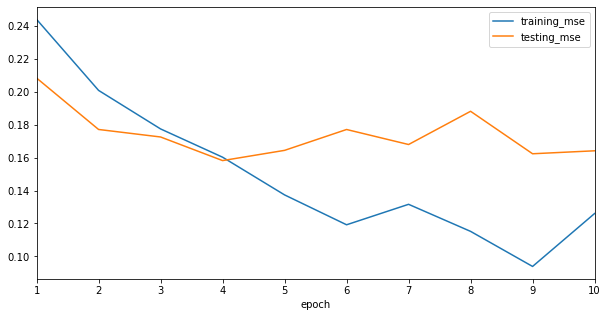

In [18]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()

# Activation Function: Swish

Pros: Moderately new, is said to perform better than the relu function

Cons: Not a default for keras, so must activate ourselves

In [19]:
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

In [20]:
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [21]:
Activation(swish)

In [22]:
batch_size = 30

# Set up Convolutional Network
model = tf.keras.models.Sequential([
  tf.keras.layers.BatchNormalization(input_shape=(108,192,1)),
  tf.keras.layers.Conv2D(8, (5,5), padding="same", activation=Activation(swish)),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(16, (5,5), padding="same", activation=Activation(swish)),
  tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
  tf.keras.layers.Conv2D(32, (2,2), padding="same", activation=Activation(swish)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, (2,2), padding="same", activation=Activation(swish)),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation=Activation(swish)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation=Activation(swish)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='linear'),
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_squared_error', 'mean_absolute_error'])

h = model.fit_generator(gather_images(train_X, train_Y, batch_size=batch_size),
                    steps_per_epoch = len(train_X)//batch_size, epochs=10, 
                    validation_data=gather_images(test_X, test_Y, batch_size=batch_size), 
                    validation_steps = len(test_X)//batch_size)

Epoch 1/10
347/347 [==============================]347/347 [==============================] - 196s 566ms/step - loss: 0.2662 - mean_squared_error: 0.2662 - mean_absolute_error: 0.2325 - val_loss: 0.2161 - val_mean_squared_error: 0.2161 - val_mean_absolute_error: 0.2245

Epoch 2/10
347/347 [==============================]347/347 [==============================] - 191s 550ms/step - loss: 0.2118 - mean_squared_error: 0.2118 - mean_absolute_error: 0.2039 - val_loss: 0.1902 - val_mean_squared_error: 0.1902 - val_mean_absolute_error: 0.2352

Epoch 3/10
347/347 [==============================]347/347 [==============================] - 191s 552ms/step - loss: 0.2060 - mean_squared_error: 0.2060 - mean_absolute_error: 0.2076 - val_loss: 0.2011 - val_mean_squared_error: 0.2011 - val_mean_absolute_error: 0.2810

Epoch 4/10
347/347 [==============================]347/347 [==============================] - 191s 551ms/step - loss: 0.1886 - mean_squared_error: 0.1886 - mean_absolute_error: 0.2019 - v

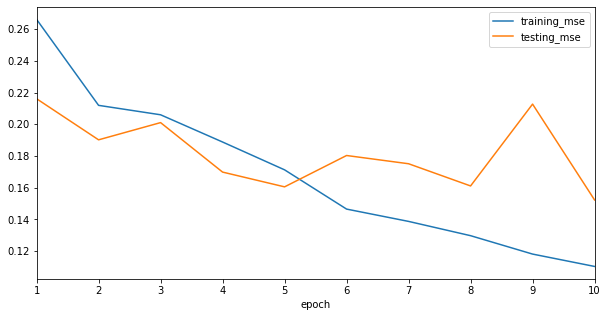

In [23]:
error_mse = pd.DataFrame({'training_mse':h.history['mean_squared_error'], 
                       'testing_mse': h.history['val_mean_squared_error'], 
                       'epoch': range(1,11,1)})

error_mse.plot('epoch', ['training_mse', 'testing_mse'], figsize=(10,5))
plt.show()